In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib
import numpy as np
import cobra

import matplotlib.ticker as ticker
import seaborn as sns

import pickle

from GenerateDynamicFuncs import *

cobra_config = cobra.Configuration()
cobra_config.solver = "cplex"

In [2]:
# Set styles to use
plt.style.use('default')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors)

## Import Biomass Composition data
Import data generated in DataProcessing.ipynb

In [3]:
macros = ['Carbohydrate', 'Protein', 'Lipid', 'RNA', 'DNA', 
          'Metals', 'H₂O', 'Pi', 'SO₄', 'Cofactors']

meas_long = pd.read_csv(f"../results/dataframes/MeasurementsLong.csv")
meas_long.rename(columns={"Name":"Macrocomponent"}, inplace=True)
meas_long[["Cultivation Group", "Sample Point"]] = meas_long.Cultivation.str.rsplit("_",1, expand=True)
meas_long = meas_long[meas_long["Cultivation Group"].isin(["SC", "C0.1"])]
meas_long = meas_long.set_index(["Cultivation Group", "Sample Point"]).sort_index()

VSMeas = pd.read_csv(f"../results/dataframes/VariableStoichMeasurements.csv", index_col=0)
VSMeas = VSMeas.set_index(["Cultivation Group", "Sample Point"]).sort_index()

Calculate the g/g CDW for each component by combining the stoichiometry of classes (e.g. DNA nucleotides) with the total of each macromolecule

In [4]:
all_sp_df = pd.DataFrame()
for ix in meas_long.index.unique():
    exp_name = ix
    var_df = VSMeas.loc[ix,:].copy()
    meas_df = meas_long.loc[ix,:].copy()
    # macro_df = meas_df[meas_df.Macrocomponent.isin(macros)]
    meas_df_sd = meas_df[meas_df.variable == "SD"]
    meas_df_mean = meas_df[meas_df.variable == "Value"]
    mass_fraction_dict = dict(zip(meas_df_mean["Macrocomponent"].values, meas_df_mean["g/g CDW"].values))
    
    var_df["g/g CDW"] = var_df.apply(lambda x: x["Value"] * mass_fraction_dict[x["Macrocomponent"]], axis=1)
    mass_fraction_dict = dict(zip(meas_df_sd["Macrocomponent"].values, meas_df_sd["g/g CDW"].values))
    var_df["g/g CDW SD"] = var_df.apply(lambda x: x["Value"] * mass_fraction_dict[x["Macrocomponent"]], axis=1)
    accounted_for = var_df.Macrocomponent.unique()
    meas_df = meas_df[~meas_df.Macrocomponent.isin(accounted_for)].copy()
    base_df = meas_df[meas_df.variable == "Value"].copy()
    base_df["g/g CDW SD"] = meas_df[meas_df.variable == "SD"]["g/g CDW"]
    base_df["Name"] = base_df["Macrocomponent"]

    sp_df = pd.concat([var_df, base_df]).drop(columns=["Cultivation", "variable", "Value"])
    all_sp_df = pd.concat([all_sp_df, sp_df])

Extra measurements of the glycogen and trehalose content of the biomass were made during the retentostat cultivation. Format the data to be combined with the previously generated data

In [5]:
sample_info = pd.read_csv(f"../data/SampleInfo.csv", index_col=0)
cul_grp_dict = sample_info["Chemostat Length"].to_dict()

carb_df = pd.read_csv(f"../data/biomass/measured/CarbComp.csv")
carb_df[["Cultivation","Sample Point"]] = carb_df.Sample.str.split("_", expand=True)
carb_df["Cultivation Group"] = carb_df["Cultivation"].apply(lambda x: cul_grp_dict.get(x))
carb_df.drop(columns="Cultivation", inplace=True)
carb_df = carb_df[carb_df.isnull().any(1)]
carb_df = carb_df[carb_df.Variable == "Mean"]
carb_df = carb_df.groupby(["Cultivation Group", "Sample Point"]).agg(["mean", "std"])
carb_df.drop("Total", axis=1, inplace=True)
carb_df.rename(columns={"Glycogen":"glycogen", "Trehalose":"alpha,alpha-trehalose"}, inplace=True)
carb_df = carb_df.stack(0)
carb_df.reset_index(inplace=True)
carb_df.rename(columns={"mean":"g/g CDW", "std":"g/g CDW SD", "level_2":"Name"}, inplace=True)
carb_df["Family"] = "Carbohydrate"
carb_df["Macrocomponent"] = "Carbohydrate"
carb_df["type"] = "measured"
carb_df = carb_df[carb_df["Cultivation Group"].isin(["SC","SS_01"])]
carb_df.set_index(["Cultivation Group", "Sample Point"], inplace=True)

Combine data and sort dataframe

In [6]:
all_sp_df = pd.concat([all_sp_df, carb_df])
all_sp_df.sort_values(by=["Cultivation Group", "Sample Point","Family"], inplace=True)
all_sp_df = all_sp_df.reset_index().drop_duplicates()
all_sp_df.set_index(["Cultivation Group", "Sample Point"], inplace=True)
all_sp_df = all_sp_df.rename(index={"SS_01":"C0.1"}).reset_index()
all_sp_df.loc[all_sp_df["Cultivation Group"] == "C0.1", "Sample Point"] = "C0.1"
all_sp_df.set_index(["Cultivation Group", "Sample Point"], inplace=True)

Import cultivation data from the retentostat cultivation. Specifically, the biomass concentration data

In [7]:
ferm_data = pd.read_csv(f"../data/FermDataDynamic.csv")


ferm_data["Cultivation Group"] = ferm_data.Cultivation.apply(lambda x :cul_grp_dict.get(x))
ferm_data = ferm_data[~ferm_data["Cultivation Group"].isnull()]

total_merged = pd.merge(all_sp_df, 
                        ferm_data.groupby(["Cultivation Group", "Sample Point"]).mean(), 
                        on=["Cultivation Group", "Sample Point"])

total_merged["Component g/L"] = total_merged["g/g CDW"] * total_merged["Biomass g/L"]
total_merged["Component g/L SD"] = total_merged["g/g CDW SD"] * total_merged["Biomass g/L"]

ferm_data = ferm_data.groupby(["Cultivation Group", "Sample Point"]).mean()
ferm_data.sort_values(by="Growth Rate model 1/h", ascending=True, inplace=True)



## Export merged dataframe of the biomass compositions

Create dictionaries for converting between different naming conventions e.g. sample point, growth rate, formatted growth rate

In [8]:
sample_point_dict = total_merged.loc["SC"]["Time d"].to_dict()
sample_point_dict = {k:str(round(v,1)) for k,v in sample_point_dict.items()}

sp_mu_dict = {'C0.1': '0.1',
             '0.0': '0.025',
             '0.9': '0.013',
             '1.9': '0.0073',
             '5.9': '0.0022',
             '7.9': '0.0017',
             '9.9': '0.0014',
             '13.9': '0.001',
             '16.9': '0.00083',
             '19.9': '0.00071',
             '23.9': '0.00059',
             '27.9': '0.00052'}
sp_gr_dict = {k:f"{v} $h^{-1}$" for k,v in sp_mu_dict.items()}

In [9]:
biomass_compositions = total_merged.sort_index().copy()
biomass_compositions.reset_index(inplace=True)
biomass_compositions.set_index("Name", inplace=True)


carbohydrate_compositions = biomass_compositions.pivot(columns="Sample Point", values=["g/g CDW", "g/g CDW SD"]).dropna().swaplevel(axis=1).sort_index(axis=1)
carbohydrate_compositions = carbohydrate_compositions.rename(columns=sample_point_dict).sort_index(axis=1)
carbohydrate_compositions = carbohydrate_compositions.loc[:,["C0.1", "0.0", "0.9", "1.9", "5.9", "9.9", "13.9", "19.9", "23.9", "27.9"]]
carbohydrate_compositions.sort_index(key=lambda x: x.str.lower(), inplace=True)
carbohydrate_compositions.to_csv(f"../results/dataframes/CarbohydrateComposition.csv")


biomass_compositions = biomass_compositions.pivot(columns="Sample Point", values=["g/g CDW", "g/g CDW SD"]).dropna(axis=1).swaplevel(axis=1).sort_index(axis=1)
biomass_compositions = biomass_compositions.rename(columns=sample_point_dict).sort_index(axis=1)
biomass_compositions = biomass_compositions.loc[:,["C0.1", "0.0", "5.9","13.9", "27.9"]]
biomass_compositions.sort_index(key=lambda x: x.str.lower(), inplace=True)
biomass_compositions.to_csv(f"../results/dataframes/BiomassCompositions.csv")


## Fit accumulation functions to the concentration of each biomass component during the retentostat

Component concentrations are calculated by multiplying the g/g CDW by the total biomass conc Cx.

Derivatives can be divided by hte viable biomass concentration and growth rate from the model, assuming only viable biomass contributes to the production of new biomass

In [10]:
retentostat_merged = total_merged.loc["SC"].sort_index().copy()
retentostat_merged.reset_index(inplace=True)
retentostat_merged.set_index("Name", inplace=True)
retentostat_merged.sort_values(by="Time d", inplace=True)

In [11]:
sort_total = total_merged.sort_values("Time h")
sort_total["Time d"] = [str(round(float(name), 3)) for name in sort_total["Time d"]]
pivot_sort = sort_total.pivot_table(index=["Cultivation Group","Sample Point", "Time d"], 
                                    columns="Name", values="g/g CDW")

# rename and format the measured stoichioemtries for consistency in plotting later
measured = pivot_sort.copy()
chemo = measured.loc["C0.1"].rename(index={"0.0":"C0.1"},level=1)

ret_measured = measured.drop("C0.1").droplevel(0)
a = ret_measured.index.get_level_values(1)
b = [round(x,1) for x in ret_measured.index.get_level_values(-1).astype(float)]
ret_measured.index = [a,b]

ret_measured.sort_index(level=-1,inplace=True)
measured = pd.concat([chemo,ret_measured])

Create vectors used in function fitting including time after retentostat initiation, biomass conc, growth rate etc

In [12]:
# Only want to extract these values fro accumulation fitting for retentostat samples
x_sp = ferm_data.loc["SC"]["Time h"].values

Cxv_sp = ferm_data.loc["SC"]["Biomass viable model g/L"].values
Cx_sp = ferm_data.loc["SC"]["Biomass model g/L"].values
mu_sp = ferm_data.loc["SC"]["Growth Rate model 1/h"].values
g_lh = Cx_sp*mu_sp 

In [13]:
x_plot = np.linspace(0,700)

plot_df = pd.DataFrame()
plot_dy_df = pd.DataFrame()

fitted_g_l = pd.DataFrame()
fitted_g_lh = pd.DataFrame()

components = retentostat_merged.index.unique()
fitted_functions = {}

for component in components:

    df = retentostat_merged.loc[component].copy()
    # df.sort_values(by="Time d", inplace=True)
    y = df["Component g/L"].values
    x = df["Time h"].values
    sigma = df["Component g/L SD"].values

    sigma[sigma == 0] = 1
    sigma[np.isnan(sigma)] = 1
    max_y = max(y)
    min_y = min(y)

    func = "asymptotic"
    rmse, r2g, popt, pcov = fit_function(x, y, [1.5*max_y,min_y, 1e-2],"asymptotic", sigma=sigma)
    y_plot, dy_plot = function_pred_and_deriv(x_plot, "asymptotic", *popt)
    y_sp, dy_sp = function_pred_and_deriv(x_sp, "asymptotic", *popt)

    if component == "glycogen":
        rmse, r2, popt, pcov = fit_function(x, y, [0,0,0,min_y],"cubic", sigma=sigma)
        y_plot, dy_plot = function_pred_and_deriv(x_plot, "cubic", *popt)
        y_sp, dy_sp = function_pred_and_deriv(x_sp, "cubic", *popt)
        func = "cubic"

    fitted_functions[component] = (func, popt)
    
    plot_df = pd.concat([plot_df, pd.DataFrame([y_plot], index=[component], columns=x_plot)])
    plot_dy_df = pd.concat([plot_dy_df, pd.DataFrame([dy_plot], index=[component], columns=x_plot)])

    fitted_g_l = pd.concat([fitted_g_l, pd.DataFrame([y_sp], index=[component], columns=x_sp)])
    fitted_g_lh = pd.concat([fitted_g_lh, pd.DataFrame([dy_sp], index=[component], columns=x_sp)])

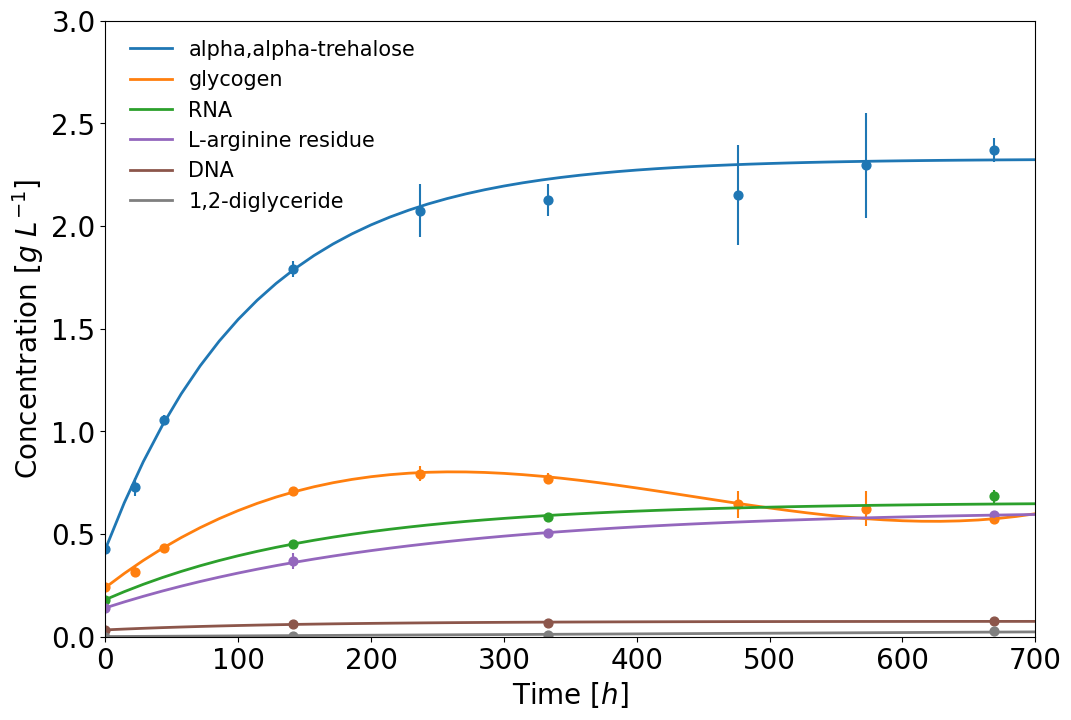

In [15]:
fig, ax = plt.subplots(1, figsize=(12,8))


comp_to_plot = ['alpha,alpha-trehalose',
                'glycogen',
                'RNA',
                'L-arginine residue',
                'DNA',
               '1,2-diglyceride']

cmap = plt.cm.get_cmap('tab10', 8)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

for i, component in enumerate(comp_to_plot):
    
    df = retentostat_merged.loc[component].copy()
    df.sort_values(by="Time d", inplace=True)
    y = df["Component g/L"].values
    x = df["Time h"].values
    sigma = df["Component g/L SD"].values
    
    ax.plot(plot_df.columns, plot_df.loc[component], linewidth=2, label=component, c=color_list[i])
    ax.vlines(x, y+sigma, y-sigma, colors=color_list[i])
    ax.scatter(x, y, s=40, c=color_list[i])
    
ax.set_xlim([0,700])

ax.set_ylim([0,3])
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('Time $[h]$',fontsize=20)
ax.set_ylabel('Concentration $[g\ L^{-1}]$',fontsize=20)


handles, labels = ax.get_legend_handles_labels()



lgd = ax.legend(bbox_to_anchor=(0.18,1),
                   loc='upper center', prop={"size":15}, frameon=False)

fig.savefig("../results/plots/5ComponentFit.png",
            bbox_inches='tight',transparent=True)

# Generate the biomass equations using the different methods

Import Molecules info - formulas/MWs

In [16]:
AllMols = pd.read_csv(f"../results/dataframes/AllMolswFormula.csv", index_col=0)
AMDict = AllMols["Average Mass"].to_dict()
macro_dict = AllMols["Macrocomponent"].to_dict()
AMDict["Pi"] = 95.98

#### Fitted equation

In [17]:
fitted_g_l.columns = ferm_data.drop("C0.1")["Time d"].to_list()
fitted_g_l.columns = [str(round(float(x),1)) for x in fitted_g_l]
fitted = fitted_g_l.copy()
fitted["0.0"] = pivot_sort.loc[("SC", "SS", "0.0"), fitted.index].T
fitted["C0.1"] = pivot_sort.loc[("C0.1", "C0.1", "0.0"), fitted.index].T
fitted_scaled = fitted.div(fitted.sum(),axis=1)

fitted_scaled_mmol = fitted_scaled.apply(lambda row: row/(AMDict[row.name]/1000), axis=1)
fitted_scaled_mmol.loc["Biomass"] = 1
fitted_scaled_mmol.to_csv(f"../results/dataframes/ScaledFittedStoich.csv")


/home/users/bcoltman/.conda/envs/memo3.7/lib/python3.7/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


#### Derived equation

In [18]:
derived = fitted_g_lh/g_lh

derived.columns = ferm_data.drop("C0.1")["Time d"].to_list()
derived = derived.reindex(sorted(derived.columns), axis=1)
derived.columns = [str(round(x,1)) for x in derived]
col_order = derived.T.columns

# Just use measured values for both chemostat phases

derived["0.0"] = pivot_sort.loc[("SC", "SS", "0.0"), col_order].T
derived["C0.1"] = pivot_sort.loc[("C0.1", "C0.1", "0.0"), col_order].T

derived_mmol = derived.apply(lambda row: row/(AMDict[row.name]/1000), axis=1)
derived_mmol.loc["Biomass"] = 1
derived_mmol.to_csv(f"../results/dataframes/DerivedStoich.csv")


derived.loc["Biomass"] = derived[derived > 0].sum()
derived_scaled = derived/(derived.loc["Biomass"])
# scaled = g_gcdw/(g_gcdw.loc["Biomass"]/0.9)

derived_scaled_mmol = derived_scaled.loc[derived_scaled.index != "Biomass"].apply(lambda row: row/(AMDict[row.name]/1000), axis=1)
derived_scaled_mmol.loc["Biomass"] = 1
derived_scaled_mmol.to_csv(f"../results/dataframes/ScaledDerivedStoich.csv")


#### Interpolated equation

In [19]:
x = ferm_data.loc["SC"]["Time d"].values

interpolated = pd.DataFrame(columns= ret_measured.columns)

for i, col in ret_measured.iteritems():
    temp = col.dropna()
    xp = temp.index.get_level_values(0).astype(float)
    fp = temp.values
    interpolated.loc[:,i] = np.interp(x, xp, fp)
interpolated.index = x


interpolated = interpolated.T#.droplevel(0,axis=1)
interpolated = interpolated.rename_axis(None, axis=0)
interpolated.columns = [str(round(x,1)) for x in interpolated]
interpolated["C0.1"] = pivot_sort.loc[("C0.1", "C0.1", "0.0"), interpolated.index].T

interpolated_scaled = interpolated.div(interpolated.sum(axis=0),axis=1)

interpolated_mmol = interpolated.apply(lambda row: row/(AMDict[row.name]/1000), axis=1)
interpolated_mmol.loc["Biomass"] = 1
interpolated_mmol.to_csv(f"../results/dataframes/InterpolatedStoich.csv")

interpolated_scaled_mmol = interpolated_scaled.apply(lambda row: row/(AMDict[row.name]/1000), axis=1)
interpolated_scaled_mmol.loc["Biomass"] = 1
interpolated_scaled_mmol.to_csv(f"../results/dataframes/ScaledInterpolatedStoich.csv")

## Calculate the fractions for the macromolecular classes
#### Measured

In [20]:
classes_measured = measured.dropna().T.droplevel(0,axis=1)
classes_measured.columns = [str(x) for x in classes_measured]
classes_measured = classes_measured.rename(columns={k:float(v) for k,v in sp_mu_dict.items()})
classes_measured = classes_measured.rename(index=macro_dict)
classes_measured = classes_measured.groupby(classes_measured.index).sum()

scaled_classes_measured  = classes_measured.div(classes_measured.sum())

#### Fitted

In [21]:
classes_fitted = fitted.rename(index=macro_dict) 
classes_fitted = classes_fitted.groupby(classes_fitted.index).sum()

scaled_classes_fitted = fitted_scaled.rename(index=macro_dict)
scaled_classes_fitted = scaled_classes_fitted.groupby(scaled_classes_fitted.index).sum()

#### Derived

In [22]:
classes_derived = derived.rename(index=macro_dict)
classes_derived = classes_derived.groupby(classes_derived.index).sum()
classes_derived.sort_values(by="0.0", ascending=False, inplace=True)
classes_derived = pd.concat([classes_derived['C0.1'], classes_derived.iloc[:,:-1]],axis=1)

scaled_classes_derived = derived_scaled.rename(index=macro_dict)
scaled_classes_derived = scaled_classes_derived.groupby(scaled_classes_derived.index).sum()
scaled_classes_derived.sort_values(by="0.0", ascending=False, inplace=True)
scaled_classes_derived = pd.concat([scaled_classes_derived['C0.1'], scaled_classes_derived.iloc[:,:-1]],axis=1)
(scaled_classes_derived*100).drop("Biomass").rename(columns=sp_mu_dict).to_csv(f"../results/dataframes/DynamicScaledMacros.csv")

#### Interpolated

In [23]:
classes_interpolated = interpolated.rename(columns={k:float(v) for k,v in sp_mu_dict.items()})
classes_interpolated = classes_interpolated.rename(index=macro_dict)
classes_interpolated = classes_interpolated.groupby(classes_interpolated.index).sum()

scaled_classes_interpolated = interpolated_scaled.rename(columns={k:float(v) for k,v in sp_mu_dict.items()})
scaled_classes_interpolated = scaled_classes_interpolated.rename(index=macro_dict)
scaled_classes_interpolated = scaled_classes_interpolated.groupby(scaled_classes_interpolated.index).sum()

#### Import the consensus and scaled consensus biomass equation to include in comparison plots

In [24]:
comp_dict = {"Protein":"PROTEIN_c", 
             "Carbohydrates":"CARBOHYDRATES_c", 
             "RNA":"RNA_c", 
             "DNA":"DNA_c", 
             "Lipids":"LIPIDS_c"}

pichia, m_warnings = cobra.io.validate_sbml_model("../results/ModelWithProduction.xml")

macro_original = {k:abs(pichia.reactions.Consensus.metabolites[pichia.metabolites.get_by_id(v)]) for k,v in comp_dict.items()}
macro_scaled = {k:abs(pichia.reactions.ScaledConsensus.metabolites[pichia.metabolites.get_by_id(v)]) for k,v in comp_dict.items()}

consensus_df = pd.concat([pd.Series(macro_original)] * len(scaled_classes_interpolated.columns.unique()),axis=1)
consensus_df.columns= scaled_classes_interpolated.columns

scaled_consensus_df = pd.concat([pd.Series(macro_scaled)] * len(scaled_classes_interpolated.columns.unique()),axis=1)
scaled_consensus_df.columns= scaled_classes_interpolated.columns

SBML errors in validation, check error log for details.
COBRA warnings in validation, check error log for details.


In [25]:
sns.set(font_scale=1.5,style="ticks")

ax_lims = {"Carbohydrates":(0,0.75),
           "Protein":(0, 0.75),
           "RNA":(0,0.12),
           "Lipids":( 0,0.12),
           "DNA":( 0,0.009)}


scf = scaled_classes_fitted.rename(columns={k:float(v) for k,v in sp_mu_dict.items()})#.drop("Biomass")
scf = scf.T.reset_index().melt(id_vars="index")
scf["Measure"] = "Fitted"

scd = scaled_classes_derived.rename(columns={k:float(v) for k,v in sp_mu_dict.items()}).drop("Biomass")
scd = scd.T.reset_index().melt(id_vars="index")
scd["Measure"] = "Derived"

sci = scaled_classes_interpolated 
sci = sci.T.reset_index().melt(id_vars="index")
sci["Measure"] = "Interpolated"

con = consensus_df
con = con.T.reset_index().melt(id_vars="index")
con["Measure"] = "Consensus"

sccon = scaled_consensus_df
sccon = sccon.T.reset_index().melt(id_vars="index")
sccon["Measure"] = "Consensus - Scaled"

all_data = pd.concat([scf, scd,sci,con, sccon],axis=0)

all_comp = all_data.pivot(columns="index", index=["variable", "Measure"], values="value")
all_comp = all_comp.rename_axis(index={"variable":"Macromolecule", "Measure":"Biomass Equation"},columns={"index":""})
all_comp.sort_index(axis=1,ascending=False,inplace=True)
all_comp = all_comp.reindex(["Consensus", "Derived", "Fitted", "Interpolated", "Consensus - Scaled"],axis=0, level=1)
all_comp = all_comp.reindex(["Carbohydrates", "Protein", "RNA", "Lipids", "DNA"],axis=0, level=0)
all_comp.to_csv(f"../results/dataframes/AllBioMacros.csv")

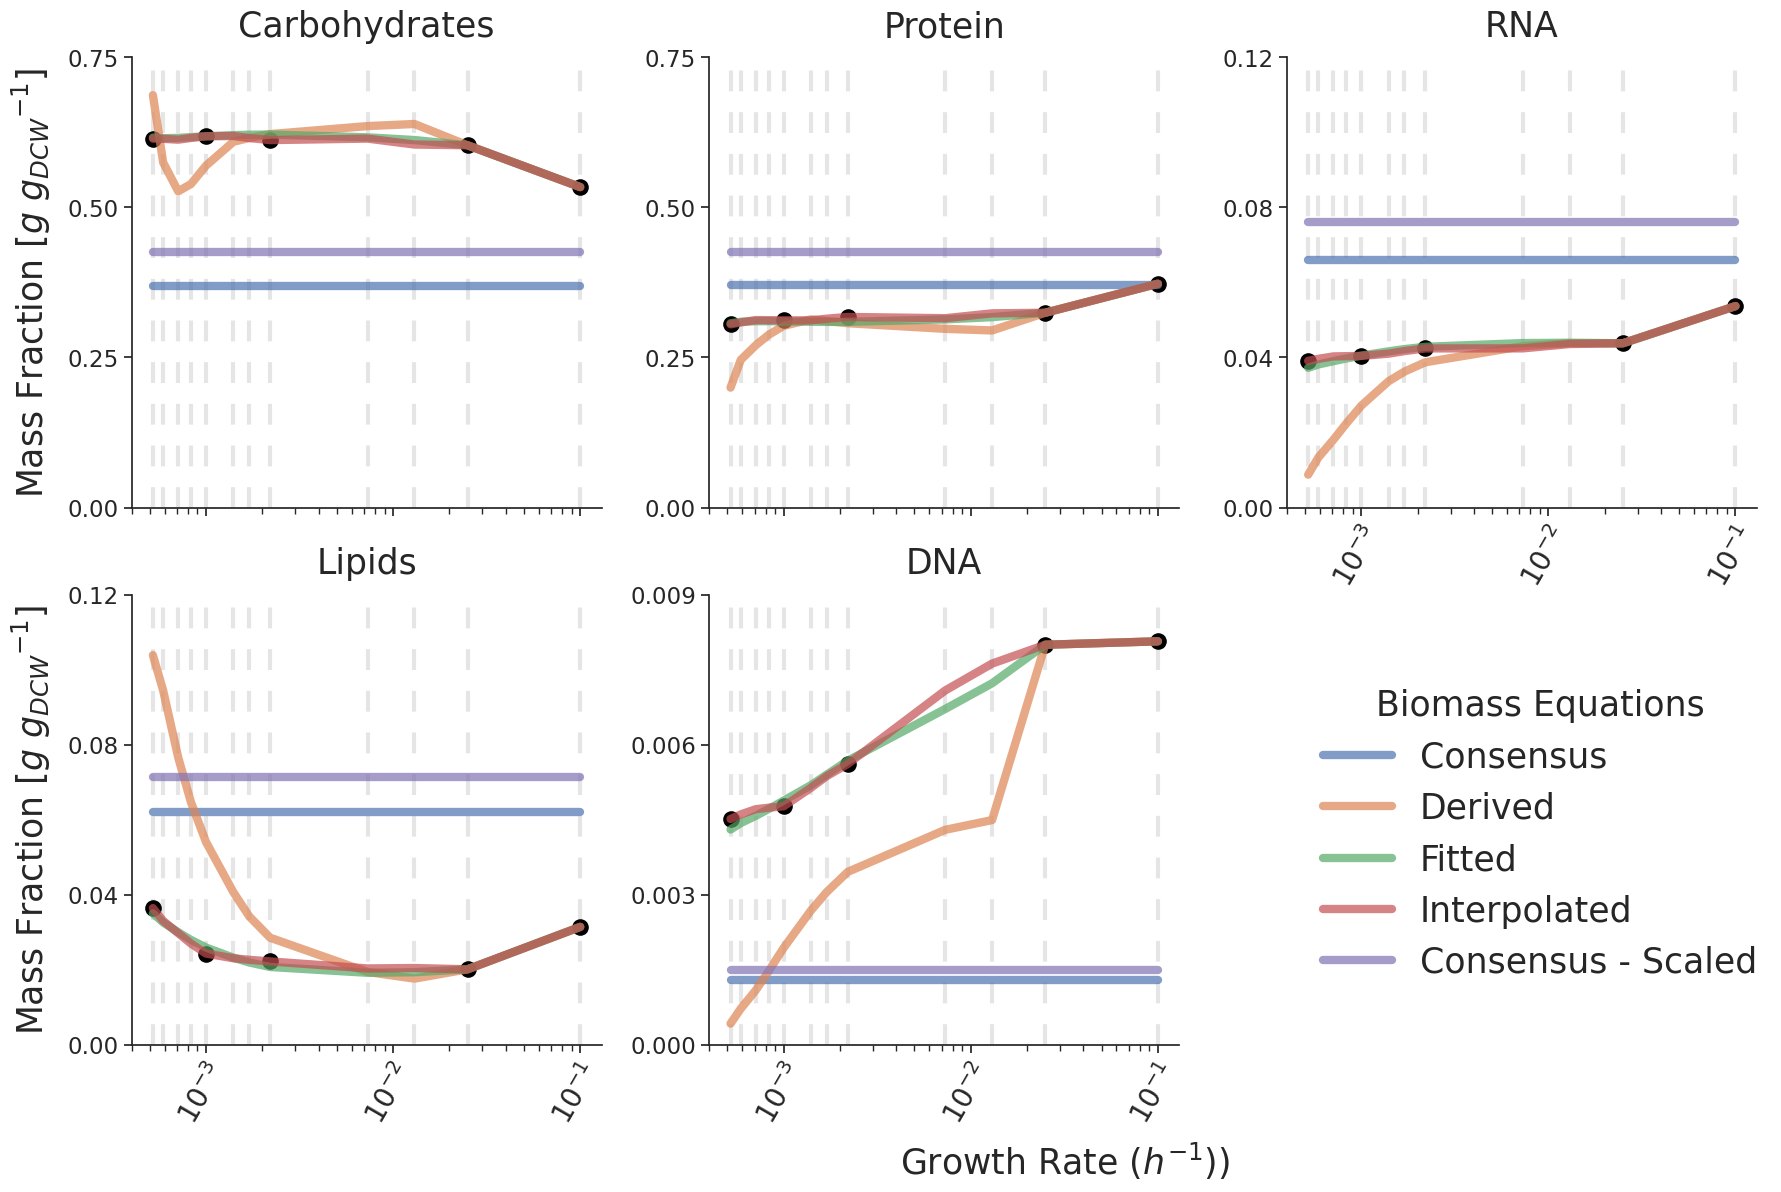

In [26]:
cmap = plt.cm.get_cmap('tab10', 10)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]#[:len(biomass_equations)]

col_dict = {'color': color_list[1:4], }

g = sns.FacetGrid(data=all_data, col="variable",hue="Measure", col_wrap=3, height=6, sharey=False,sharex=True,
                  hue_order=["Consensus", "Derived", "Fitted", "Interpolated", "Consensus - Scaled"],
                  col_order=ax_lims.keys())
                  # hue_order=["Consensus", "Derived - scaled", "Fitted - scaled", "Interpolated - scaled"],col_order=ax_lims.keys())
g.map(sns.lineplot, "index", "value", lw=6,alpha=.7,palette="tab10")#,palette="muted")

g.add_legend(loc="upper left", bbox_to_anchor=(.58, .4), title="Biomass Equations",prop={"size":25}) #fontsize=25,title_fontsize=60)

g.legend.get_title().set_fontsize(25)
g.set_axis_labels('','Mass Fraction $[g\ {g_{DCW}}^{-1}]$')
g.set_titles(col_template="{col_name}")

plt.subplots_adjust(top=0.9)


for ax in g.axes.ravel():
   
    to_plot = classes_measured.loc[ax.get_title(),:]
      
    x = to_plot.index
    y = to_plot.values
 
    
    to_plot = scaled_classes_measured.loc[ax.get_title()]
    x = to_plot.index
    y = to_plot.values
    ax.scatter(x,y,s=120, c="black")
    for x in classes_interpolated.columns:
        ax.axvline(x, linestyle="--", dashes=(5,5),color="black",zorder=0, alpha=0.1, lw=3)
    
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), size=20, rotation=60, ha="right", rotation_mode='anchor')
    
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=25, labelpad=15)
    
    l = ax.get_ylabel()
    ax.set_ylabel(l, fontsize=25, labelpad=10)
    ax.set_ylim(ax_lims[ax.get_title()])
    
    l = ax.get_title()
    ax.set_title(l, fontsize=25, pad=15)   
    ax.yaxis.set_major_locator(ticker.MaxNLocator(3))
g.set(xscale="log")
g.fig.text(0.48, -0.02, r'Growth Rate ($h^{-1})$)', ha='center', va='center', fontsize=25)
g.fig.subplots_adjust()
    
g.savefig(f"../results/plots/DynBiomassScaled.png", dpi=300, transparent=True)


## Compare the stoichioemtries of the different methods
## Determine the delta in stoichioemtric coefficients between the different comparisons

In [28]:
col_order = fitted_scaled_mmol.loc[:,::-1].columns

# interpolated
rel_int = interpolated_scaled_mmol.div(derived_scaled_mmol.loc[:, col_order])
rel_int = rel_int.rename(columns={k:float(v) for k,v in sp_mu_dict.items()}).sort_index(axis=1)
rel_int.index = rel_int.index.set_names(["Component"])
rel_int = rel_int.melt(ignore_index=False)
rel_int = rel_int.reset_index()
rel_int["Comparison"] = "Interpolated/Derived"

# fitted
rel_fit = fitted_scaled_mmol.div(derived_scaled_mmol.loc[:, col_order])
rel_fit = rel_fit.rename(columns={k:float(v) for k,v in sp_mu_dict.items()}).sort_index(axis=1)
rel_fit.index = rel_fit.index.set_names(["Component"])
rel_fit = rel_fit.melt(ignore_index=False)
rel_fit = rel_fit.reset_index()
rel_fit["Comparison"] = "Fitted/Derived"

rel_intfit = fitted_scaled_mmol.div(interpolated_scaled_mmol)
rel_intfit = rel_intfit.rename(columns={k:float(v) for k,v in sp_mu_dict.items()}).sort_index(axis=1)
rel_intfit.index = rel_intfit.index.set_names(["Component"])
rel_intfit = rel_intfit.melt(ignore_index=False)
rel_intfit = rel_intfit.reset_index()
rel_intfit["Comparison"] = "Fitted/Interpolated"

data_df = pd.concat([rel_int, rel_fit, rel_intfit])
data_df.loc[:, "value"] = np.log2(data_df.loc[:,"value"])

slowest = data_df.loc[data_df["variable"] == min(data_df["variable"])].copy()
slowest["abs value"] = slowest["value"].abs()
large_delta = slowest.sort_values(by="abs value",ascending=False)
large_delta.drop_duplicates("Component").head(10)

/home/users/bcoltman/.conda/envs/memo3.7/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Component,variable,value,Comparison,abs value
31,"alpha,alpha-trehalose",0.00052,4.177372,Interpolated/Derived,4.177372
13,L-glutamine residue,0.00052,3.956517,Fitted/Derived,3.956517
14,L-glutamic acid residue,0.00052,3.956517,Fitted/Derived,3.956517
6,DNA,0.00052,3.420806,Interpolated/Derived,3.420806
23,zymosterol ester,0.00052,-2.220951,Fitted/Derived,2.220951
30,RNA,0.00052,2.158673,Interpolated/Derived,2.158673
38,"1,2-diglyceride",0.00052,-2.084926,Fitted/Derived,2.084926
30,ergosteryl ester,0.00052,-2.057775,Fitted/Derived,2.057775
36,Ceramide,0.00052,-1.995144,Fitted/Derived,1.995144
24,triglyceride,0.00052,-1.992387,Fitted/Derived,1.992387


#### For each growth rate specific equation, calculated the median delta for the stoichioemtric coefficients between two methods, then look at the min and max across all equations

In [29]:
median_delta = pd.concat([rel_int, rel_fit, rel_intfit]).groupby(["Comparison","variable"]).median().groupby("Comparison").agg(["min", "max"])
median_delta

value          
                           min       max
Comparison                              
Fitted/Derived        0.834485  1.076731
Fitted/Interpolated   0.962746  1.004922
Interpolated/Derived  0.837441  1.120779

#### Plot a box plot for the delta between each method for each growth rate specific biomass equation

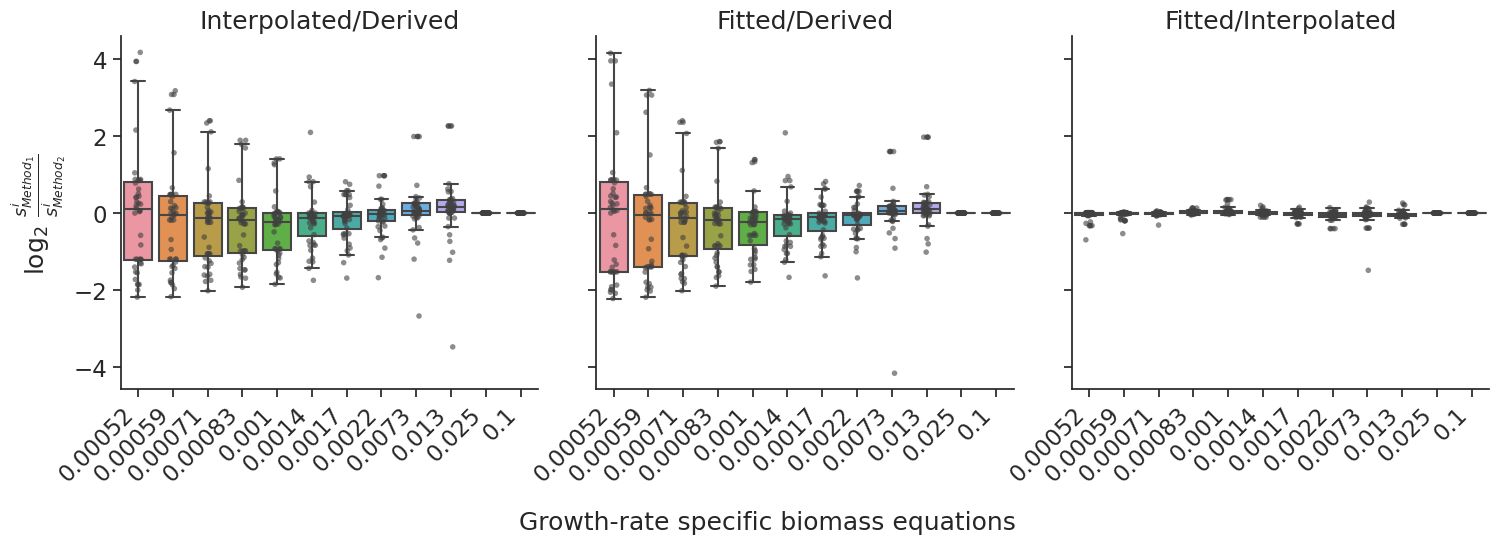

In [30]:
g = sns.catplot(
    data=data_df,
    x="variable", y="value", col="Comparison",col_wrap=3,
    kind="box", orient="v",showfliers=False)
g.map_dataframe(sns.stripplot, x="variable", y="value", 
                palette=["#404040"], 
                alpha=0.6, dodge=True, s=4)

g.set_titles(col_template="{col_name}")
g.set(xlabel="", ylabel=r"log$_2$ $\frac{s^i_{Method_1}}{s^i_{Method_2}}$")
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    
g.fig.text(0.5, -0.08, r'Growth-rate specific biomass equations', ha='center', va='center', fontsize=18)
g.savefig(f"../results/plots/Log2RelativeStoich.png", dpi=300, transparent=True,bbox_inches="tight")

Plot each individual fit separately for investigating/comparisons

In [37]:
# Create the PdfPages object to which we will save the pages:
# The with statement makes sure that the PdfPages object is closed properly at
# the end of the block, even if an Exception occurs.

with PdfPages('../results/plots/SingleFitsDYn.pdf') as pdf:

    components = retentostat_merged.index.unique()

    for typ in ["measured"]:#, "reconciled"]:
        for component in components:
           
            fig, ax = plt.subplots(1, figsize=(12,8))

           
            df = retentostat_merged.loc[component].copy()
            df.sort_values(by="Time h", inplace=True)
            
            
            y = df["Component g/L"].values
            x = df["Time h"].values
            sigma = df["Component g/L SD"].values
            
            mask = y == 0
            y[mask] = 1e-10 # y[~mask]
            sigma[sigma == 0] = 1
            sigma[np.isnan(sigma)] = 1
            
            max_y = max(y)
            min_y = min(y)

            x_plot = np.linspace(0,28*24)
            
            

            rmse, r2l, popt, pcov = fit_function(x, y, [0, min_y],"linear", sigma=sigma)
            y_plot, dy_plot = function_pred_and_deriv(x_plot, "linear", *popt)
            ax.plot(x_plot, y_plot, linewidth=3, label="Linear")
        
            rmse, r2q, popt, pcov = fit_function(x, y, [0,0, min_y],"quadratic", sigma=sigma)
            y_plot, dy_plot = function_pred_and_deriv(x_plot, "quadratic", *popt)
            ax.plot(x_plot, y_plot, linewidth=3, label="Quadratic")
        
            rmse, r2c, popt, pcov = fit_function(x, y, [0,0,0, min_y],"cubic", sigma=sigma)
            y_plot, dy_plot = function_pred_and_deriv(x_plot, "cubic", *popt)
            ax.plot(x_plot, y_plot, linewidth=3, label="Cubic")
            r2qu = 0
            r2qui = 0
            
            
            rmse, r2a, popt, pcov = fit_function(x, y, [1.5*max_y,min_y, 1e-2],"asymptotic", sigma=sigma)
            y_plot, dy_plot = function_pred_and_deriv(x_plot, "asymptotic", *popt)
            ax.plot(x_plot, y_plot, linewidth=3, label="Asymptotic")
            
            # Specifying bounds necessary for GOmpertz, otherwise fails
            bounds = ([0, 0, 0], np.inf)
            # Good starting values if well represented by gompertz function
            rmse, r2g, popt, pcov = fit_function(x, y, [1.5*max_y,min_y, max_y/100],"gompertz", bounds=bounds, sigma=sigma)
            y_plot, dy_plot = function_pred_and_deriv(x_plot, "gompertz", *popt)
            ax.plot(x_plot, y_plot, linewidth=3, label="Gompertz")
            
            if component == "(1->4)-beta-D-mannan":
                p0 = [1e-3, -1e3, 1e2, min_y]
            else:
                p0 = [0,0,0,min_y]
                
            if len(x) > 4:
                rmse, r2qu, popt, pcov = fit_function(x, y, [0,0,0, 0,min_y],"quartic", sigma=sigma)
                y_plot, dy_plot = function_pred_and_deriv(x_plot, "quartic", *popt)
                ax.plot(x_plot, y_plot, linewidth=3, label="Quartic")

            
            r2_str = f"R^2 values\nLinear = {r2l:.4f}\nQuadratic = {r2q:.4f}\n" \
                    f"Cubic = {r2c:.4f}\nAsymptotic = {r2a:.4f}\nGompertz = {r2g:.4f}" \
                    "\nQuartic = {r2qu:.4f}" # f"\nError func = {r2e:.4f}
            props = dict(boxstyle='round', facecolor='white', alpha=0.5)
          
            ax.text(0.9, 0.15, r2_str, transform=ax.transAxes, fontsize=14,
            verticalalignment='center', horizontalalignment='right', bbox=props)

            sigma[sigma == 1] = x[sigma == 1] *0.1
            ax.scatter(x, y, c='black', zorder=2)
            ax.errorbar(x, y, yerr=sigma)
            ax.tick_params(axis='both', which='major', labelsize=20)
            ax.set_xlabel('Time (d)',fontsize=20)
            ax.set_ylabel('Mass (g/l)',fontsize=20)
            ax.set_title(f'Curve fit to total of {component}',fontsize=20,pad=15)
            ax.legend(bbox_to_anchor=(0,1),loc='upper left')
            
            pdf.savefig() 
            plt.close()


/home/users/bcoltman/.conda/envs/memo3.7/lib/python3.7/site-packages/scipy/optimize/_lsq/common.py:115: RuntimeWarning: divide by zero encountered in true_divide
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
/home/users/bcoltman/.conda/envs/memo3.7/lib/python3.7/site-packages/scipy/optimize/_lsq/common.py:115: RuntimeWarning: divide by zero encountered in true_divide
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
/home/users/bcoltman/.conda/envs/memo3.7/lib/python3.7/site-packages/scipy/optimize/_lsq/common.py:115: RuntimeWarning: divide by zero encountered in true_divide
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
/home/users/bcoltman/.conda/envs/memo3.7/lib/python3.7/site-packages/scipy/optimize/_lsq/common.py:115: RuntimeWarning: divide by zero encountered in true_divide
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
